# Final Notebook for 42186 Model-Based Machine Learning 
### Mathias Niemann Tygesen s153583, Frederik Boe Hüttel s151689 and David Frich Hansen s144242
This notebook contains the final results of the project

The notebook contains 3 different modeling approaches and implementations - the first 2 models where covered in the *Milestone 2* notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pandas as pd
import pystan_utils
import networkx as nx

plt.style.use('ggplot')
%matplotlib inline

## Latent space model
One way to model network data is to assume that each node has a latent position in $D$-dimensional Euclidean space and that the rates are dependent on the relative distance between he nodes in this latent space. This is the framework of Hoff, Raftery and Handcock in [2]. As the weights in the network (that is, the observations), we model the likelihood as iid. Poisson variables whose rates depend on the relative distance between the nodes in the latent space as is done [here](http://edwardlib.org/tutorials/latent-space-models).

The latent positions are drawn from an isotropic multivariate Gaussian with 0 mean and diagonal covariance, $\lambda I$ where $I$ denotes the identity matrix of appropriate size (ie. $D\times D$). The variance parameter $\lambda$ is drawn from a noninformative uniform prior (improper from 0 to $\infty$).

The likelihood of the model is then as such,

$$ p(X|\theta) = \prod_{i\neq j} p(x_{i,j} | \boldsymbol{z}_i,\boldsymbol{z}_j)$$

where $\boldsymbol{z}_n$ denotes the $D$-dimensional latent position of node $n$.  
Each term in the likelihood is Poisson, with rate depending on the positions,
$$p(x_{i,j} | \boldsymbol{z}_i,\boldsymbol{z}_j) = Poisson\left(\frac{1}{\| \boldsymbol{z}_i - \boldsymbol{z}_j\|}\right)$$

such that two positions that are close to eachother in latent space has a higher Poisson rate and on average, we'll observe a higher weight between them (in this framework, this corresponds to more interactions between different characters in Game of Thrones). $\|\cdot\|$ denotes the Euclidean 2-norm such that $\|x-y\|$ is the Euclidean distance between $x$ and $y$.


The generative model is then as such:

 1. Draw $\lambda$ from a non-informative improper prior (this is done by not explicitly defining a prior in STAN).
 2. for $n = 1..N$
     * draw $\boldsymbol{z}_n \sim \mathcal{N}(0, \lambda I)$ where $I$ is of size $D \times D$
 3. for all pairs $i,j\in \{1,2,\ldots,N\}\times\{1,2,\ldots,N\}$ where $i\neq j$
     * draw $x_{i,j} \sim Poisson\left(\frac{1}{\| \boldsymbol{z}_i - \boldsymbol{z}_j\|}\right)$
     

From this we get the factorization of the joint probabiltiy:

$$p(X, \boldsymbol{z}, \lambda) = \prod_{i\neq j} [p(x_{i,j} | \boldsymbol{z}_i, \boldsymbol{z}_j)] \prod_{n=1}^N [p(\boldsymbol{z}_n | 0, \lambda)] p(\lambda)$$

and the corresponding PGM

![PGM2](https://i.imgur.com/RumjQEV.png)

which of course is very simple.

Below the model is implemented in STAN


In [2]:
# see http://edwardlib.org/tutorials/latent-space-models

model_code = """
data { 
    int<lower=2> N; // number of nodes
    int<lower=1> D; // dimension of latent space
    int<lower=0> X[N,N]; // adjacency matrix
} parameters { 
    matrix[N,D] z; // latent positions in space
    real<lower=0> lambda; // std
} model {

    for (d in 1:D) z[:,d] ~ normal(0, lambda);
    for (i in 1:N){
        for (j in 1:N) {
            if (i == j) continue;
            X[i,j] ~ poisson(1.0 / (distance(z[i,:], z[j,:]) + 1e-6)); // can either be this or maybe poisson(exp(alpha-dist)) where alpha ~ normal(0, sigma) where lambda is small
        }
    }
    
}
"""



In [3]:
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_271a92d5bbb05c03435b49986fc4caff NOW.
/home/david/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp2wc6gu7o/stanfit4anon_model_271a92d5bbb05c03435b49986fc4caff_2789849423090957834.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


### Test on Synthetic data
We generate a small network and test the model here. 

/home/david/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


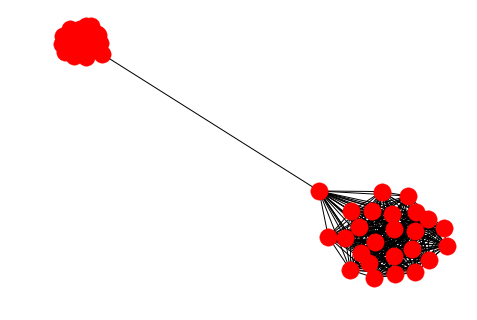

In [4]:
# Generate small network to test on
num_each = 50
G = nx.barbell_graph(num_each,0)

# Generate the notes with different number of edges.
mat = nx.to_numpy_array(G, dtype=int)
rate1 = 5
rate2 = 100
mat1 = np.random.poisson(rate1, size=(num_each//2, num_each//2))
mat1 = np.tril(mat1) + np.tril(mat1,k=-1).T
mat2 = np.random.poisson(rate2, size=mat1.shape)
mat2 = np.tril(mat2) + np.tril(mat2, k=-1).T

mat = np.array(np.block([[mat1, np.zeros(mat1.shape, dtype=int)], [np.zeros(mat1.shape, dtype=int), mat2]]))
np.fill_diagonal(mat, 0)
mat[0,-1] = mat[-1,0] = np.random.poisson(8)

# Draw graph
G = nx.from_numpy_array(mat)
nx.draw(G)

Here we see two very distinct clusters. This means we should see two similar clusterings in the two-dimensional Euclidean space. The data is generated by generating two independent Poisson 'blocks' and generating the network accordingly. In this case, we have two very different rates, so the two clusters are very distict.

In [5]:
#data = {'X' : mat, 'N' : mat.shape[0], 'D' : 2}
#fit = sm.sampling(data, chains=1, iter=10000) 

### EXTREMELY SLOW FOR THE DATA ABOVE


There is a problem¸however. Compared to a Stochastic Block Model (see below), we see that the clusters are not modelled explicitly. This is a problem if the in-group rates are very different like here (100 for one group and 5 for the other in one of our experiments). In this case, the group with the higher rate should be put very close together, which may happen at the cost of the other group positions due to the shared variance parameter $\lambda$. The inference process was very slow in this case, and we gave it up due to time constraints.

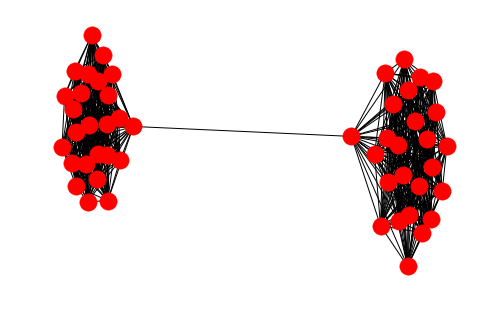

In [6]:
num_each = 50
G = nx.barbell_graph(num_each,0)

# Generate the notes with different number of edges.
mat = nx.to_numpy_array(G, dtype=int)
rate1 = 5
rate2 = 8
mat1 = np.random.poisson(rate1, size=(num_each//2, num_each//2))
mat1 = np.tril(mat1) + np.tril(mat1,k=-1).T
mat2 = np.random.poisson(rate2, size=mat1.shape)
mat2 = np.tril(mat2) + np.tril(mat2, k=-1).T

mat = np.array(np.block([[mat1, np.zeros(mat1.shape, dtype=int)], [np.zeros(mat1.shape, dtype=int), mat2]]))
np.fill_diagonal(mat, 0)
mat[0,-1] = mat[-1,0] = np.random.poisson(8)

# Draw graph
G = nx.from_numpy_array(mat)
nx.draw(G)

In [7]:
#data = {'X' : mat, 'N' : mat.shape[0], 'D' : 2}
#fit = sm.sampling(data, chains=1, iter=10000) 

## ALSO EXTREMELY SLOW

Setting the parameters close to eachother was also very slow. This was probably due to the shared variance parameter $\lambda$. This makes the model relatively unflexible, as the only thing influencing the rate is the inverse distance. If the distance required to model the data well (ie. get high likelihood) is very different in different parts of the network, we are constraining ourselves by having all latent positions $\boldsymbol{z}_n$ share variances. This results in many samples being rejected by NUTS, and so slow sampling. A way to fix this, could be to model the groups explicitly.  
This is exactly the case in the Stochastic Block Model introduced below.

A note should be made regarding the general perfomance of the latent space approach. As noted in [2], this approach works suprisingly well for binary networks. In this case, the likelihood becomes an 'augmented Bernoulli-logistic' framework, where we say that the probability of observing a link is like in Bayesian logistic regression where the distance between the latent positions is one of the features in the logistic regression. This also allows for easy inclusion of covariate information of the nodes. Perhaps we could implement a similar frameowrk here, as Poisson regression, but we have chosen to work with the Stochastic Block Model framework instead.

---

## Stochastic Block Model with Poisson/Gamma observations


We are trying to do analysis on a weighted (positive integer weights), undirected network on interactions between characters in Game of Thrones using a Stochastic Block Model (SBM) as introduced by [1]. The idea behind the SBM is very similar to LDA or Gaussian Mixture Models, where we assume that each node comes from a mixture component, and the Poisson rate for an edge between node $i$ and node $j$ is dependent on what mixture component $i$ and $j$ belongs to respectively.


### Modelling
#### Theory
As mentioned above we will fit a Stochastic Block Model (SBM) to the Game of Thrones data. The SBM is a mixture model where we assume that each node belongs to a single mixture component. Since each edge connects two nodes its likelihood will depend on the corresponding two mixture components. We let $N$ denote the number of nodes and $K$ denote the number of mixture components. $K$ is a hyperparameter that in the STAN framework needs to be pre-specified. A way to model $K$ directly on the data could be to set a large maximum number of mixture components, and then put sparsity priors on the group sizes to penalize the model for adding new groups.

We assume that the edges are i.i.d and hence get that the likelihood of the network takes the form:
$$ p(X|\theta) = \prod_{i\neq j} p(x_{i,j}|z_i, z_j, \phi) $$
Where $\theta = \{ \{z_i \}_{i=1}^N, \phi\}$. Here $z_i$ indicates which mixture component the $i$th node belongs to and $\phi$ denotes any further parameters depending on the distribution. 
A simple choice of distribution would be a Poisson distribution. Then each probability in the product would be
$$ p(x_{i,j} | z_i, z_j, \lambda) = Poisson(\lambda_{z_i,z_j})  $$
Where $\lambda$ is a matrix with the rates between groups s.t. $\lambda_{i,j}$ is the rate between group $i$ and $j$. We choose to assume that $\lambda_{i,j} \sim Gamma(a,b)$ where $a$ and $b$ are chosen hyperparameters and are all independent.
Next we assume the node mixture indicators $z_i$ to come from a $K$-dimensional categorical distribution
$$ p(z_i = k | \pi) = \pi_k  $$
where $\pi = \{ \pi_k\}_{k=1}^K$ and $\sum_{k=1}^k \pi_k = 1$.  
Equivalently, we can let the vector of mixture assignments follow a multinomial distribution with $N$ trials and $\pi$ as probability vector.  
We assume that $\pi$ is Dirichlet distributed with prior $\alpha$. Initially we choose all elements of $\alpha$ to have the same value as the apriori sizes of the groups are the same.

From the above modelling we get the following generative process:
* Given parameters $a$, $b$ and $\alpha$
    1. draw $\pi \sim Dirichlet(\alpha)$
    2. for $n = 1..N$
        * draw $z_i \sim Categorical(\pi)$
    3. draw $\lambda \sim Gamma(a,b)$
    4. for all $i,j$ where $i \neq j$
        * draw $x_{i,j} \sim Poisson(\lambda_{z_i,z_j})$

Which can also be depicted in a PGM, where we use the $\boldsymbol{z}\sim Multinomial(N, \pi)$ formulation, as well as the fact that $\lambda$ is actutally $K\times K$ i.i.d Gamma distributed (hence no plate in the PGM):
![PGM1](https://i.imgur.com/tLcH5KT.png)

However as STAN (ie. NUTS) does not handle discrete latent variables well, we cannot directly infer $\boldsymbol{z}$ in the above model. This is a well known shortcoming STAN well documented in chapter 5 of the 'STAN User's Guide'. The work around is marginalizing out the discrete variables in the likelihood by summing:

$$ p(x_{i,j}|\lambda) = \sum_{k=1}^K \sum_{k'=1}^K \text{Categorical}(z_i = k|\pi)\text{Categorical}(z_j = k'|\pi)\text{Poisson}(x_{i,j}| \lambda_{k,k'})    $$

In the implementation in STAN we transfer the above to the log scale for numerical reasons.

Below is an implementation in STAN where we infer $\lambda$ in the above model using the marginalization work around.

The next step is we want to recover the mixture components for each node $z_i$ out. To do this we will follow the STAN user guide example given here: https://mc-stan.org/docs/2_18/stan-users-guide/summing-out-the-responsibility-parameter.html.

We want the probability that a node is in a given group given the data. This is still a work in progress, but so far we have using Bayes' rule:
$$ p(z_n = k_1 |X, \pi, \lambda) = \frac{\prod_{i=1}^{N}(\prod_{k_2=1}^K(p(x_{i,n} | z_n = k_1, z_i = k_2, \lambda)p(z_i = k_2 | \pi))p(z_n = k_1 | \pi)}{\sum_{k_1=1}^K(\prod_{i=1}^{N}(\prod_{k_2=1}^K(p(x_{i,n} | z_n = k_1, z_i = k_2, \lambda)p(z_i = k_2 | \pi))p(z_n = k_1 | \pi)} $$

By putting in the distributions and converting to the log scale we should be able to implement this into STAN in the "generated quantiles" code block.
(This however has not been implemented as we changed the model to a Mixed Membership Model, as we will get to later.)

In [8]:
model_code= """
data{
       int<lower=1> N;                    // number of nodes
        int X[N,N];                       // adjacency matrix
        int<lower=2> K;                   // number of groups
        vector[K] alpha;                  // prior for dirichlet distribution
        real a;                           // priors on lambda
        real b;
} parameters {
        simplex[K] pi;                     // group sizes
        vector<lower=0>[K*(K+1)/2] lambda; // rates between groups
} model{
        matrix[K,K] log_mix_prop;          // log mixing proportions,
        matrix[K,K] lps;                   

        matrix[K,K] tmp = rep_matrix(0, K, K); // temp varible
        
        int count = 1;                    // variables used to ensure symmetry of lambda
        int len = K*(K+1)/2;
        
        pi ~ dirichlet(alpha); // prior on group sizes,
        
        for(k in 1:len){
            lambda[k] ~ gamma(a, b);
        }
        
        for(k1 in 1:K){
            for(k2 in k1:K){
                    tmp[k1, k2] = lambda[count];
                    count = count+1;
            }
        }
        tmp = tmp + tmp' - diag_matrix(diagonal(tmp)); // tmp is symmetric
        
        // cache mixing proportions
        for (k1 in 1:K) {
            for (k2 in 1:K) {
                log_mix_prop[k1, k2] = log(pi[k1]) + log(pi[k2]);
            }
        }
        
        // likelihood,
        for (i in 1:N) {
            for (j in 1:N) {
                if (i == j) continue; // ignore diagonal
                lps = log_mix_prop; // reset log probs
                for (k1 in 1:K) {
                    for (k2 in 1:K) {
                        lps[k1, k2] += poisson_lpmf(X[i,j] | tmp[k1,k2]);
                    }
                }
                target += log_sum_exp(lps);
            }
        }
}
"""

In [9]:
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6fadd9731aa1101ffb210242481d4c16 NOW.
/home/david/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp3hy4g12g/stanfit4anon_model_6fadd9731aa1101ffb210242481d4c16_4918365431449138964.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


There is an issue with the symmetry of the marginalization over $\boldsymbol{z}$ in the process above. If the groups are of approximately equal size (eg. $\pi_i\approx \pi_j$) all the contributions from the mixture components are almost the same (eg. corresponding elements of the matrix `log_mix_prop` are the same, or very close - note also that `log_mix_prop` is always symmetric) - then their contribution doesn't matter to the fit - it is simply a constant added onto the likelihood in the model block. As all elements of $\lambda$ are drawn independently, we cannot then assume that the structure of $\lambda$ (eg. that $\lambda_{z_i,z_j}$ correspond to the rate between groups $z_i$ and $z_j$ is preserved. In this case, we can only expect to get the correct rates, but not the position of them - especially in the case of 2 groups). This was seen frequently when testing, and really decreases interpretability of the parameters.

Furthermore, as the network is undirected, we have enforced that $\lambda$ is symmetric. This, however, doesn't solve the problem above. A way to solve this could be to incorporate the prior knowledge that in-group links generally have higher rates than between-group rates, thus putting a different prior on the diagonal elements of $\lambda$. 

The problem should lessen if the groups are of very different sizes, however.  

There is also a problem with label-switching. The SBM is essentially a latent clustering algorithm - and so, the likelihood only depends on the partitioning of the nodes; not on the labels of the clusters. Thus, in this formulation, it is not possible to run several Markov chains in parallel and then 'average' them when looking at the results.


### Test on synthetic data
In order to test our model we generate a simple network strcture to test on. The data is generated by generating the adjacency matrix directly. We generate two blocks of Poisson random variables with different rates (below it's 5 and 100), and visualize the network. This would allow us to recover the rates in $\lambda$, but as the groups are of equal size, we cannot assume that the structure of $\lambda$ is entirely correct.

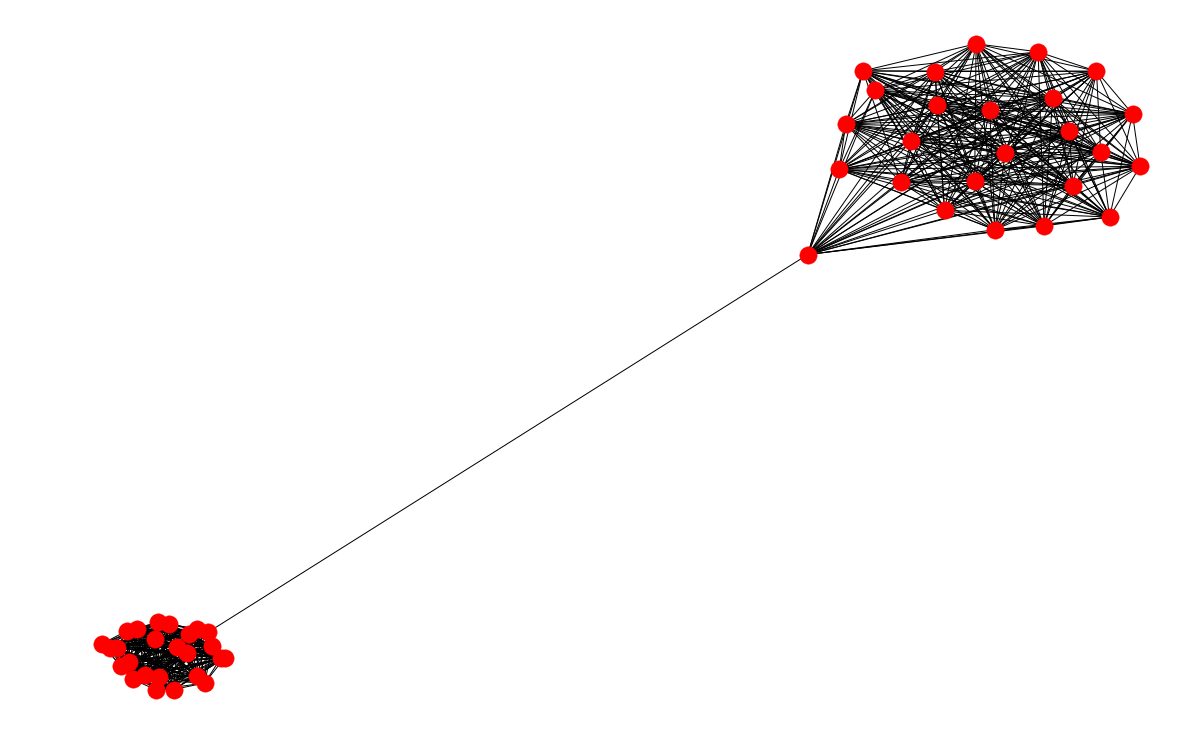

In [10]:
# Generate small network to test on
num_each = 50
G = nx.barbell_graph(num_each,0)

# Generate the notes with different number of edges.
mat = nx.to_numpy_array(G, dtype=int)
rate1 = 5
rate2 = 100
mat1 = np.random.poisson(rate1, size=(num_each//2, num_each//2))
mat1 = np.tril(mat1) + np.tril(mat1,k=-1).T
mat2 = np.random.poisson(rate2, size=mat1.shape)
mat2 = np.tril(mat2) + np.tril(mat2, k=-1).T

mat = np.array(np.block([[mat1, np.zeros(mat1.shape, dtype=int)], [np.zeros(mat1.shape, dtype=int), mat2]]))
np.fill_diagonal(mat, 0)
mat[0,-1] = mat[-1,0] = np.random.poisson(8)

# Draw graph
G = nx.from_numpy_array(mat)
plt.figure(figsize=(16,10))
nx.draw(G)

This will be the test graph. Cleary we can see the two mixture components with different rates.

In [11]:
data = {'X' : mat, 'N' : mat.shape[0], 'K' : 2, 'alpha' : np.ones(2), 'a' : 7.5, 'b' : 1}
fit = sm.sampling(data=data, iter=10000, chains=1)

In [12]:
fit

Inference for Stan model: anon_model_6fadd9731aa1101ffb210242481d4c16.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
pi[1]       0.36  9.6e-5 7.1e-3   0.35   0.36   0.36   0.37   0.38   5474    1.0
pi[2]       0.64  9.6e-5 7.1e-3   0.62   0.63   0.64   0.64   0.65   5474    1.0
lambda[1]   5.13  1.3e-3    0.1   4.94   5.06   5.13   5.19   5.32   5489    1.0
lambda[2]  99.73  5.1e-3    0.4  98.94  99.46  99.73  100.0 100.51   6217    1.0
lambda[3]   0.01  5.3e-5 3.9e-3 6.7e-3   0.01   0.01   0.02   0.02   5359    1.0
lp__       -6415    0.03   1.45  -6419  -6416  -6415  -6414  -6414   2774    1.0

Samples were drawn using NUTS at Tue May 14 14:59:29 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Examining the fit we see that the different mixtures aswell as the different rates in the groups as used to generate the data are recovered, but the positions in $\lambda$ may not be correct. In this example, they are, as STAN is column-major and the way we force $\lambda$ to be symmetric - but we have seen examples where this is not the case. 

Similarly, we also see label switching from run to run, but this is to be expected as the likelihood depends on the partitioning of the ndoes - not the labels of them.

### Test on real data
#### Data import
Import of the datafiles. The contents of the dataset can be seen in the intial initial_notebook.

In short the data concist of an undireced network between persons in the TV series Game of thrones. 

We want to infer communities in the network based on the observed edges in the network. The observed data is represented through the adjacency matrix of the network of size $N \times N$ such that N is the observed number of nodes (ie. characters). Then $X[i,j] = w$ is the observed number of interactions, w, between character i and j. $X$ is symmetric, as the network is undirected.

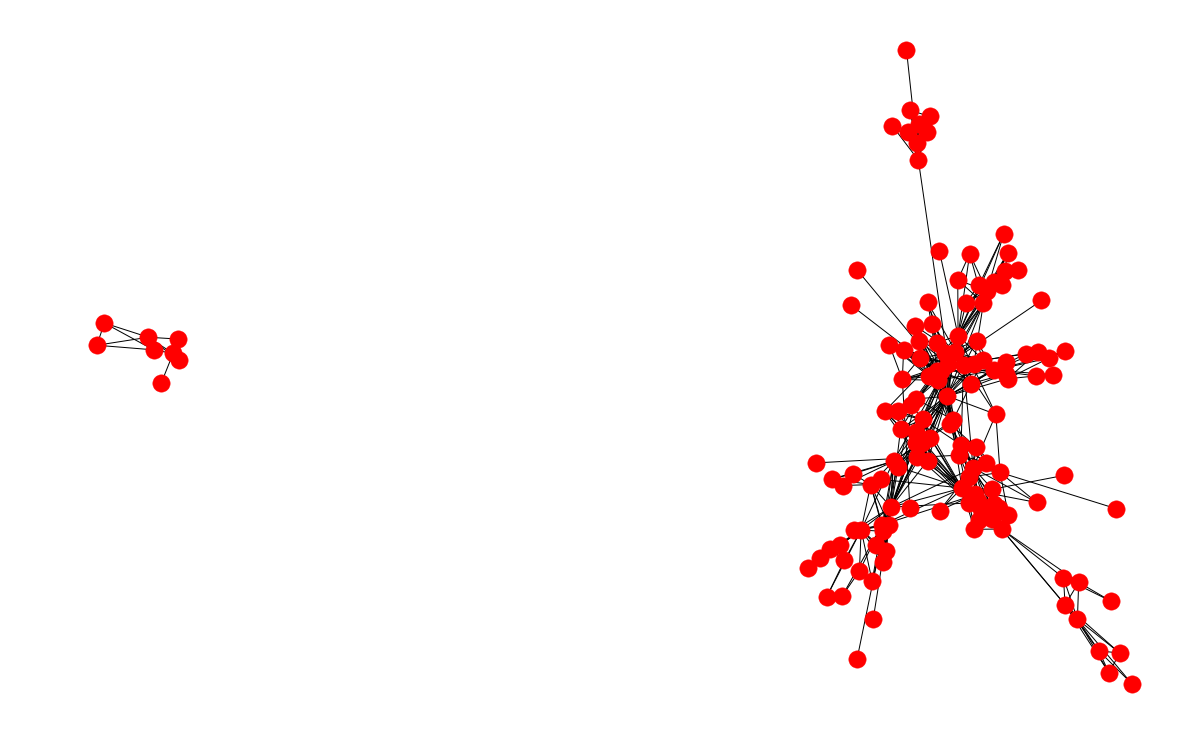

In [13]:
# load nodes and edges from file
nodes = pd.read_csv('../data/got-s6-nodes.csv')
edges = pd.read_csv('../data/got-s6-edges.csv')

# Initialize the graph based on the data from Game of Thrones Season 6
G = nx.Graph(name='Game Of Thrones S06')
G.add_nodes_from(nodes['Id'])
edge_dict = [(x['Target'],x['Source'], {'weight' : x['Weight']}) for (_,x) in edges.iterrows()]
G.add_edges_from(edge_dict)

# Conver to numpy to use with STAN
graph = nx.to_numpy_matrix(G, dtype=int)
plt.figure(figsize=(16,10))
nx.draw(G, color='r')

The season 6 graph also concist of distinct grahps. So initially we se the mixturinging components to be 2

In [14]:
n = len(nodes)+1
k = 2
data = {'X' : graph, 'N' : n, 'K' : k, 'alpha' : np.ones(2), 'a' : 7.5, 'b' : 1}
fit = sm.sampling(data=data, iter=500, chains=1)

In [15]:
fit

Inference for Stan model: anon_model_6fadd9731aa1101ffb210242481d4c16.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
pi[1]       0.97  4.8e-5 9.1e-4   0.97   0.97   0.97   0.97   0.97    358    1.0
pi[2]       0.03  4.8e-5 9.1e-4   0.03   0.03   0.03   0.03   0.03    358    1.0
lambda[1] 3.9e-4  1.2e-5 1.5e-4 1.5e-4 2.9e-4 3.7e-4 4.6e-4 7.9e-4    164    1.0
lambda[2]   6.04  5.2e-3   0.08   5.89   5.98   6.05    6.1   6.22    266    1.0
lambda[3]  47.08    0.05   0.82  45.47  46.46   47.1  47.59  48.68    241   1.01
lp__       -8896    0.13   1.45  -8900  -8897  -8896  -8895  -8894    127    1.0

Samples were drawn using NUTS at Tue May 14 15:01:55 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

So something is not quite right. The mean of $\pi$ doesn't quite get the sizes right. This may be due to label switching or the fact the $K=2$ might not be the best fit (in fact, it may very well not be as the variance of the weights is quite large in this network). This depends on the different 'true rates' in the graph. It may also be because of the relatively few samples (`n_eff` is quite low), and although `Rhat` is $\sim 1.0$, we may not get a right mean here, as ~200 samples are not much for a distribution of this dimensionality. 

# RECOVERING MIXTURE PROBABILITIES HERE!!! Model averaging, hypotheses etc.

## Mixed Membership Model
One of the problems of he Stochastic Block model is to the ambiguity in recovering the clustering labels $z_i$. So instead we consider a Mixed membership model [3], where each $x_{i,j}$ can be in multiple groups weighted by the corresponding $\pi_i$ and $\pi_j$. This allows a weighting of the rates in $\lambda$ such that $x_{ij} = \text{Poisson}(\pi_i^T\lambda\pi_j)$. In this model, we avoid the issue of recovering the discrete parameters $z_i$ in the normal SBM, as everything is continuous and thus easily handled by STAN.  
The generative model is then as such.

1. For $n = 1..N$
    - draw $\pi_n \sim \text{Dirichlet}(\boldsymbol{\alpha})$
2. For $k,k' = \{1,2,\ldots,K\}\times \{1,2,\ldots,K\}$ where $k\neq k'$ 
    - draw $\lambda_{k,k'} \sim \text{Gamma}(a,b)$
3. For $k$ in $1..K$
    - draw $\lambda_{k,k} \sim\text{Gamma}(c,d)$
4. for all pairs $i,j \in \{1,2,....N\}\times\{1,2,...N\}$ where $i \neq j$
    - $x_{i,j} \sim \text{Poisson}(\pi_i^T\lambda\pi_j);$
We get the joint probability

\begin{equation*}
\begin{aligned}
p(X, \boldsymbol{\pi}, \lambda)=&\prod_{i \neq j}p\left(x_{i, j} | \boldsymbol{\pi}_{i}^T\lambda \boldsymbol{\pi}_{j}\right) \prod_{n=1}^{N} p\left(\boldsymbol {\pi}_{n} | \alpha\right) \\
&\prod_{k\neq k'}^K p(\lambda_{k,k'}|a,b) \prod_{k=1}^K p(\lambda_{k,k}|c,d)
\end{aligned}
\end{equation*}

The PGM can be seen below.

![PGMMMSBM](https://i.imgur.com/EPYibht.png)

This model allows us to extract the probabilities $\pi_i$ which holds the probabilies of $x_i$ being in each of the mixture components of our models. 

As we shall see, we are able to use the ADVI Variational Inference algorithm to perform inference on this model.


In [16]:
model_code= """
data{
        int<lower=1> N;                    // number of nodes
        int X[N,N];                       // adjacency matrix
        int<lower=2> K;                   // number of groups
        vector[K] alpha;                  // prior for dirichlet distribution
        real a;                           // priors on lambda
        real b;                           // priors on lambda
        real c;                           // priors on lambda for diagonal
        real d;                           // priors on lambda for diagonal
} parameters {
        simplex[K] pi[N];                     // group sizes
        matrix<lower=0>[K,K] lambda; // rates between groups
} model{
        for(n in 1:N){
            pi[n] ~ dirichlet(alpha);
        }
        
        for(k in 1:K){
            for(j in 1:K)
                if(j==k){
                    lambda[k,j] ~ gamma(c,d);
                }else{
                    lambda[k,j] ~ gamma(a,b);
                }
        }
        
        for(i in 1:(N-1)){
            for(j in (i+1):N){     // assuming that X is symmetric
                X[i,j] ~ poisson(pi[i]'*lambda*pi[j]);
            }
        }

}
"""

In [17]:
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c5730e1defb06ef68cf8bcc4f385f3d9 NOW.
/home/david/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpz9xjfc3r/stanfit4anon_model_c5730e1defb06ef68cf8bcc4f385f3d9_2607134490207194082.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


### Test on synthetic data
Firstly we'll test the data on some simulated data

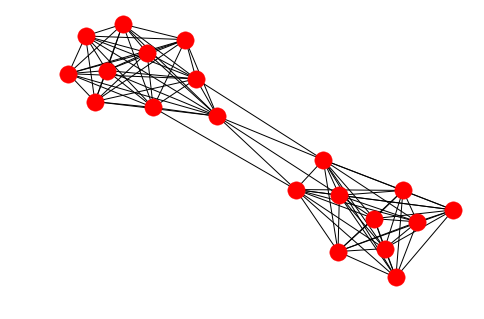

In [18]:
num_each = 20
G = nx.barbell_graph(num_each,0)

# Generate the notes with different number of edges.
mat = nx.to_numpy_array(G, dtype=int)
rate1 = 5
rate2 = 5
between = 10
mat1 = np.random.poisson(rate1, size=(num_each//2, num_each//2))
mat1 = np.tril(mat1) + np.tril(mat1,k=-1).T
mat2 = np.random.poisson(rate2,size=(num_each//2, num_each//2))
mat2 = np.tril(mat2) + np.tril(mat2, k=-1).T


mat = np.array(np.block([[mat1, np.zeros(mat1.shape, dtype=int)], [np.zeros(mat1.shape, dtype=int), mat2]]))
np.fill_diagonal(mat, 0)

mat[0,-1] = mat[-1,0] = np.random.poisson(between)
mat[0,-2] = mat[-2,0] = np.random.poisson(between)
mat[1,-2] = mat[-2,1] = np.random.poisson(between)
mat[2,-2] = mat[-2,2] = np.random.poisson(between)
mat[2,-3] = mat[-3,2] = np.random.poisson(between)

# Draw graph
G = nx.from_numpy_array(mat)
nx.draw(G)

In [19]:
n = num_each
k = 2
alpha = np.ones(2)
data = {'X' : mat, 'N' : n, 'K' : k, 'alpha' : alpha, 'a' : 7.5, 'b' : 1, 'c':5, 'd':3}
fit = sm.vb(data=data, iter=10000)

We can then color the nodes based on the mixed membership. First we extract the membership values

In [20]:
pi = np.zeros((n,k))
for i in range(n):
    for j in range(1,k+1):
        pi[i][j-1] = np.mean(fit['sampler_params'][(j-1)*n + i])
        

We can then color the nodes using a colormap. Here we have chosen that being completely sure on group 1 corresponds to dark red and completely sure on group 2 corresponds to dark blue. Lighter values inbetween blue and red corresponds to a mixed membership between the groups.

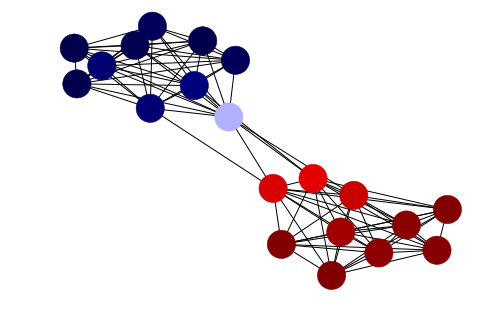

In [21]:
nx.draw(G, node_color=pi[:,0], node_size=800, cmap=plt.cm.seismic)

# Sparsity on $\alpha$
One might have some prior knowledge of the numbers groups, $K$ the network.  However if this is unknown, we can add a sparse prior onαas to penalize the model if more components are non-empty. We still need to specify a maximum number of components.  
We specify a reasonable amount of components $K$, and allow for three times as many, $K_\text{max}=3K$. The prior puts very low probability on the size of components with labels $k>K$ but it is possible for the model to assign probability to these components. If  

In [22]:
def sparse_alpha(A, K):
    alpha = np.zeros(3*K)
    alpha[:K] = A
    
    for idx,i in enumerate(range(K,3*K)):
        alpha[i] = A*np.exp(-0.25*idx)
    
    return alpha

### Test on Real Data

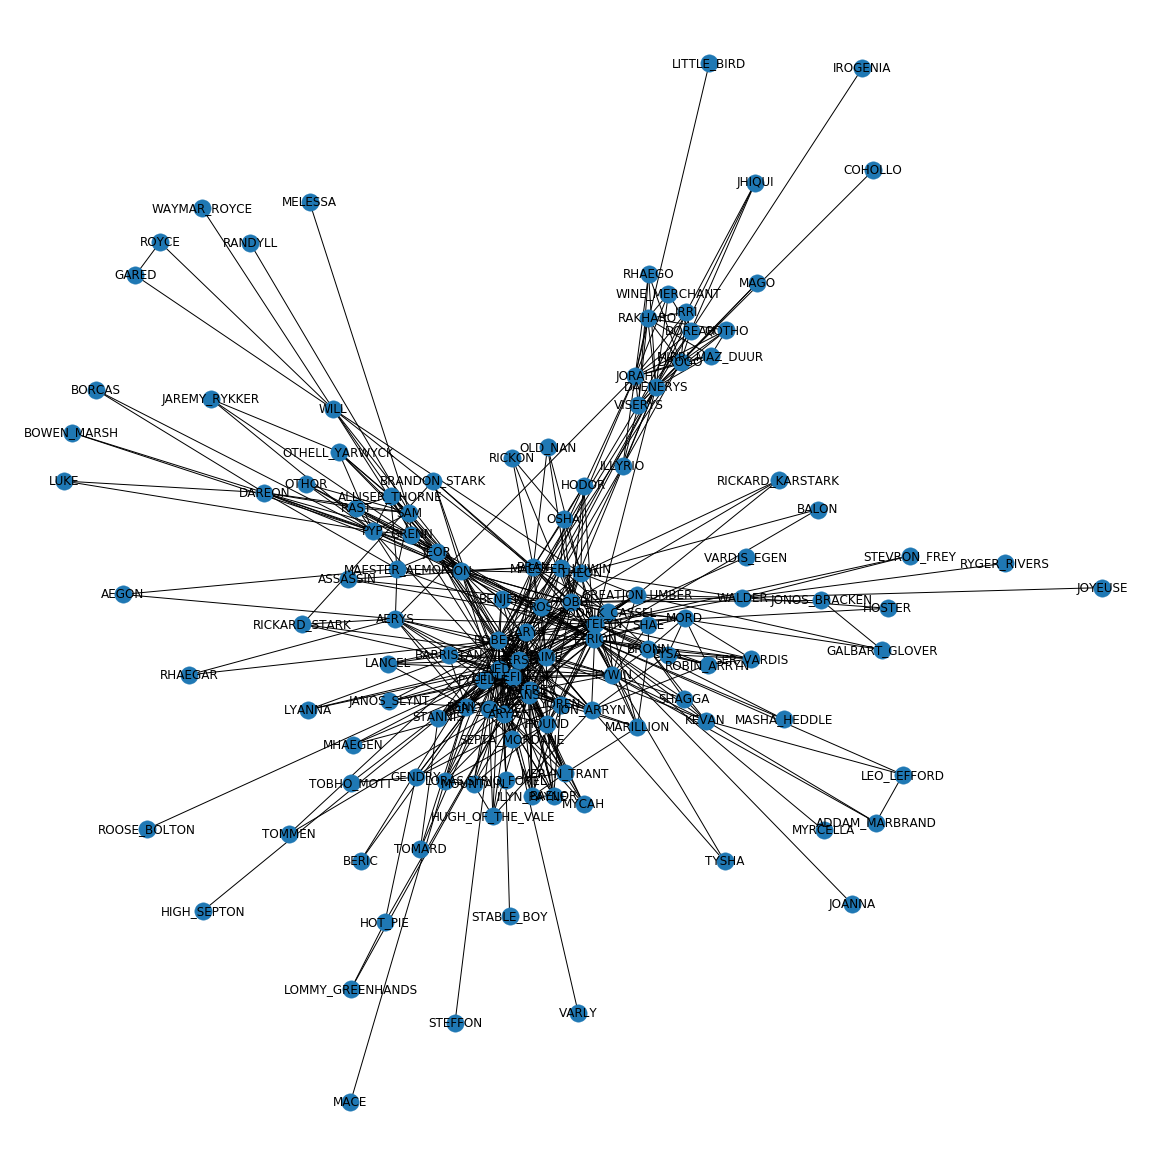

In [27]:
# load nodes and edges from file
nodes = pd.read_csv('../data/got-s1-nodes.csv')
edges = pd.read_csv('../data/got-s1-edges.csv')

# Initialize the graph based on the data from Game of Thrones Season 6
G = nx.Graph(name='Game Of Thrones S06')
G.add_nodes_from(nodes['Id'])
edge_dict = [(x['Target'],x['Source'], {'weight' : x['Weight']}) for (_,x) in edges.iterrows()]
G.add_edges_from(edge_dict)

# Conver to numpy to use with STAN
graph = nx.to_numpy_matrix(G, dtype=int)
plt.figure(figsize=(16,16))
nx.draw(G, color='r', label = nodes["Label"], with_labels=True)

In [33]:
n = graph.shape[0]
k = 5
iterations = 10000
alpha = np.ones(k)
#alpha = sparse_alpha(5, k)
data = {'X' : graph, 'N' : n, 'K' : k, 'alpha' : alpha, 
        'a' : 7.5, 'b' :  0.1, 'c': 0.5,'d': 0.5}

In [53]:
fit = sm.vb(data = data, iter = iterations, output_samples = iterations, seed = 12345)
fitvar = pystan_utils.vb_extract(fit)

One  of  the  advantages  of  the  Mixed  Membership  model  isthat a character can be in multiple groups.  One of the maincharactersDaenerys Targaryen is a main character - she onlyinteracts with a few characters such asSer Jorah Mormonta nd Khal Drogo.  Both these two have a high probability of being in group 3 as can be seen below


However for the character herself Danerys Targaryen is also highly probable to beloing to (1).  This is due to her en-emies mentioning her alot.  For example the character Cersei Lannisteris part of (1) and is one of Danerys Targary enenemies

(0, 1)

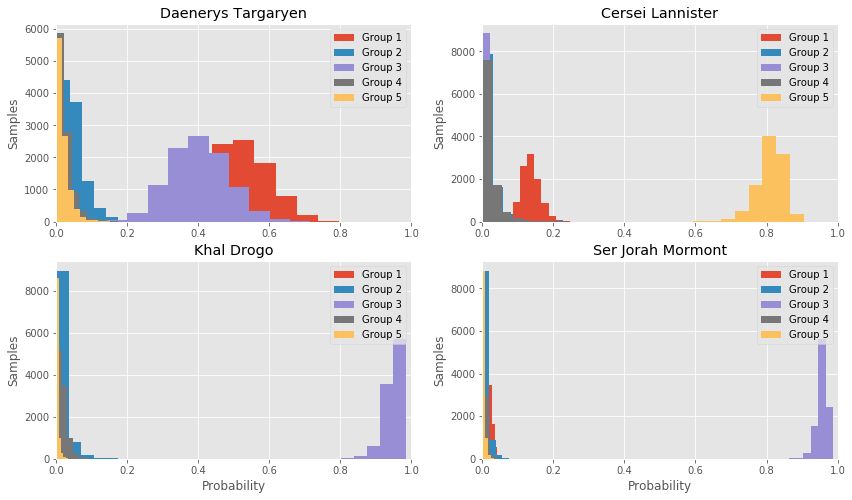

In [54]:
fitvar = pystan_utils.vb_extract(fit)
# Drogo
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.hist(fitvar[0]['pi[20,1]'], label = 'Group 1')
plt.hist(fitvar[0]['pi[20,2]'], label = 'Group 2')
plt.hist(fitvar[0]['pi[20,3]'], label = 'Group 3')
plt.hist(fitvar[0]['pi[20,4]'], label = 'Group 4')
plt.hist(fitvar[0]['pi[20,5]'], label = 'Group 5')
plt.legend(loc='upper right')
plt.title("Daenerys Targaryen")
plt.ylabel("Samples")
plt.xlim(0,1)


plt.subplot(2,2,2)
plt.hist(fitvar[0]['pi[18,1]'], label = 'Group 1')
plt.hist(fitvar[0]['pi[18,2]'], label = 'Group 2')
plt.hist(fitvar[0]['pi[18,3]'], label = 'Group 3')
plt.hist(fitvar[0]['pi[18,4]'], label = 'Group 4')
plt.hist(fitvar[0]['pi[18,5]'], label = 'Group 5')
plt.legend(loc='upper right')
plt.title("Cersei Lannister")
plt.ylabel("Samples")
plt.xlim(0,1)


plt.subplot(2,2,3)
plt.hist(fitvar[0]['pi[23,1]'], label = 'Group 1')
plt.hist(fitvar[0]['pi[23,2]'], label = 'Group 2')
plt.hist(fitvar[0]['pi[23,3]'], label = 'Group 3')
plt.hist(fitvar[0]['pi[23,4]'], label = 'Group 4')
plt.hist(fitvar[0]['pi[23,5]'], label = 'Group 5')
plt.legend(loc='upper right')
plt.title("Khal Drogo")
plt.ylabel("Samples")
plt.xlabel("Probability")
plt.xlim(0,1)


plt.subplot(2,2,4)
plt.hist(fitvar[0]['pi[49,1]'], label = 'Group 1')
plt.hist(fitvar[0]['pi[49,2]'], label = 'Group 2')
plt.hist(fitvar[0]['pi[49,3]'], label = 'Group 3')
plt.hist(fitvar[0]['pi[49,4]'], label = 'Group 4')
plt.hist(fitvar[0]['pi[49,5]'], label = 'Group 5')
plt.legend(loc='upper right')
plt.title("Ser Jorah Mormont")
plt.ylabel("Samples")
plt.xlabel("Probability")
plt.xlim(0,1)

plt.tight_layout()

We can then also plot the memberships the model found on the GoT data on the graph. However we run into some problem with visualizing mixed membership in the 5 groups. Since rgb only have 3 dimensions (red, green and blue) two of the groups will have to correspond to colors that will be mixtures of the other groups. Hence a node that belongs to a mixture of 3 groups with "pure" colors can end up with a color that corresponds to one of the other groups, without having any membership in it!.

Hence we will have to resort to just color the node corresponding to the group which it have the highest membership in.

In [52]:
pi = np.zeros((n,k))
for i in range(n):
    for j in range(1,k+1):
        pi[i][j-1] = np.mean(fit['sampler_params'][(j-1)*n + i])

groups = np.argmax(pi, axis = 1)

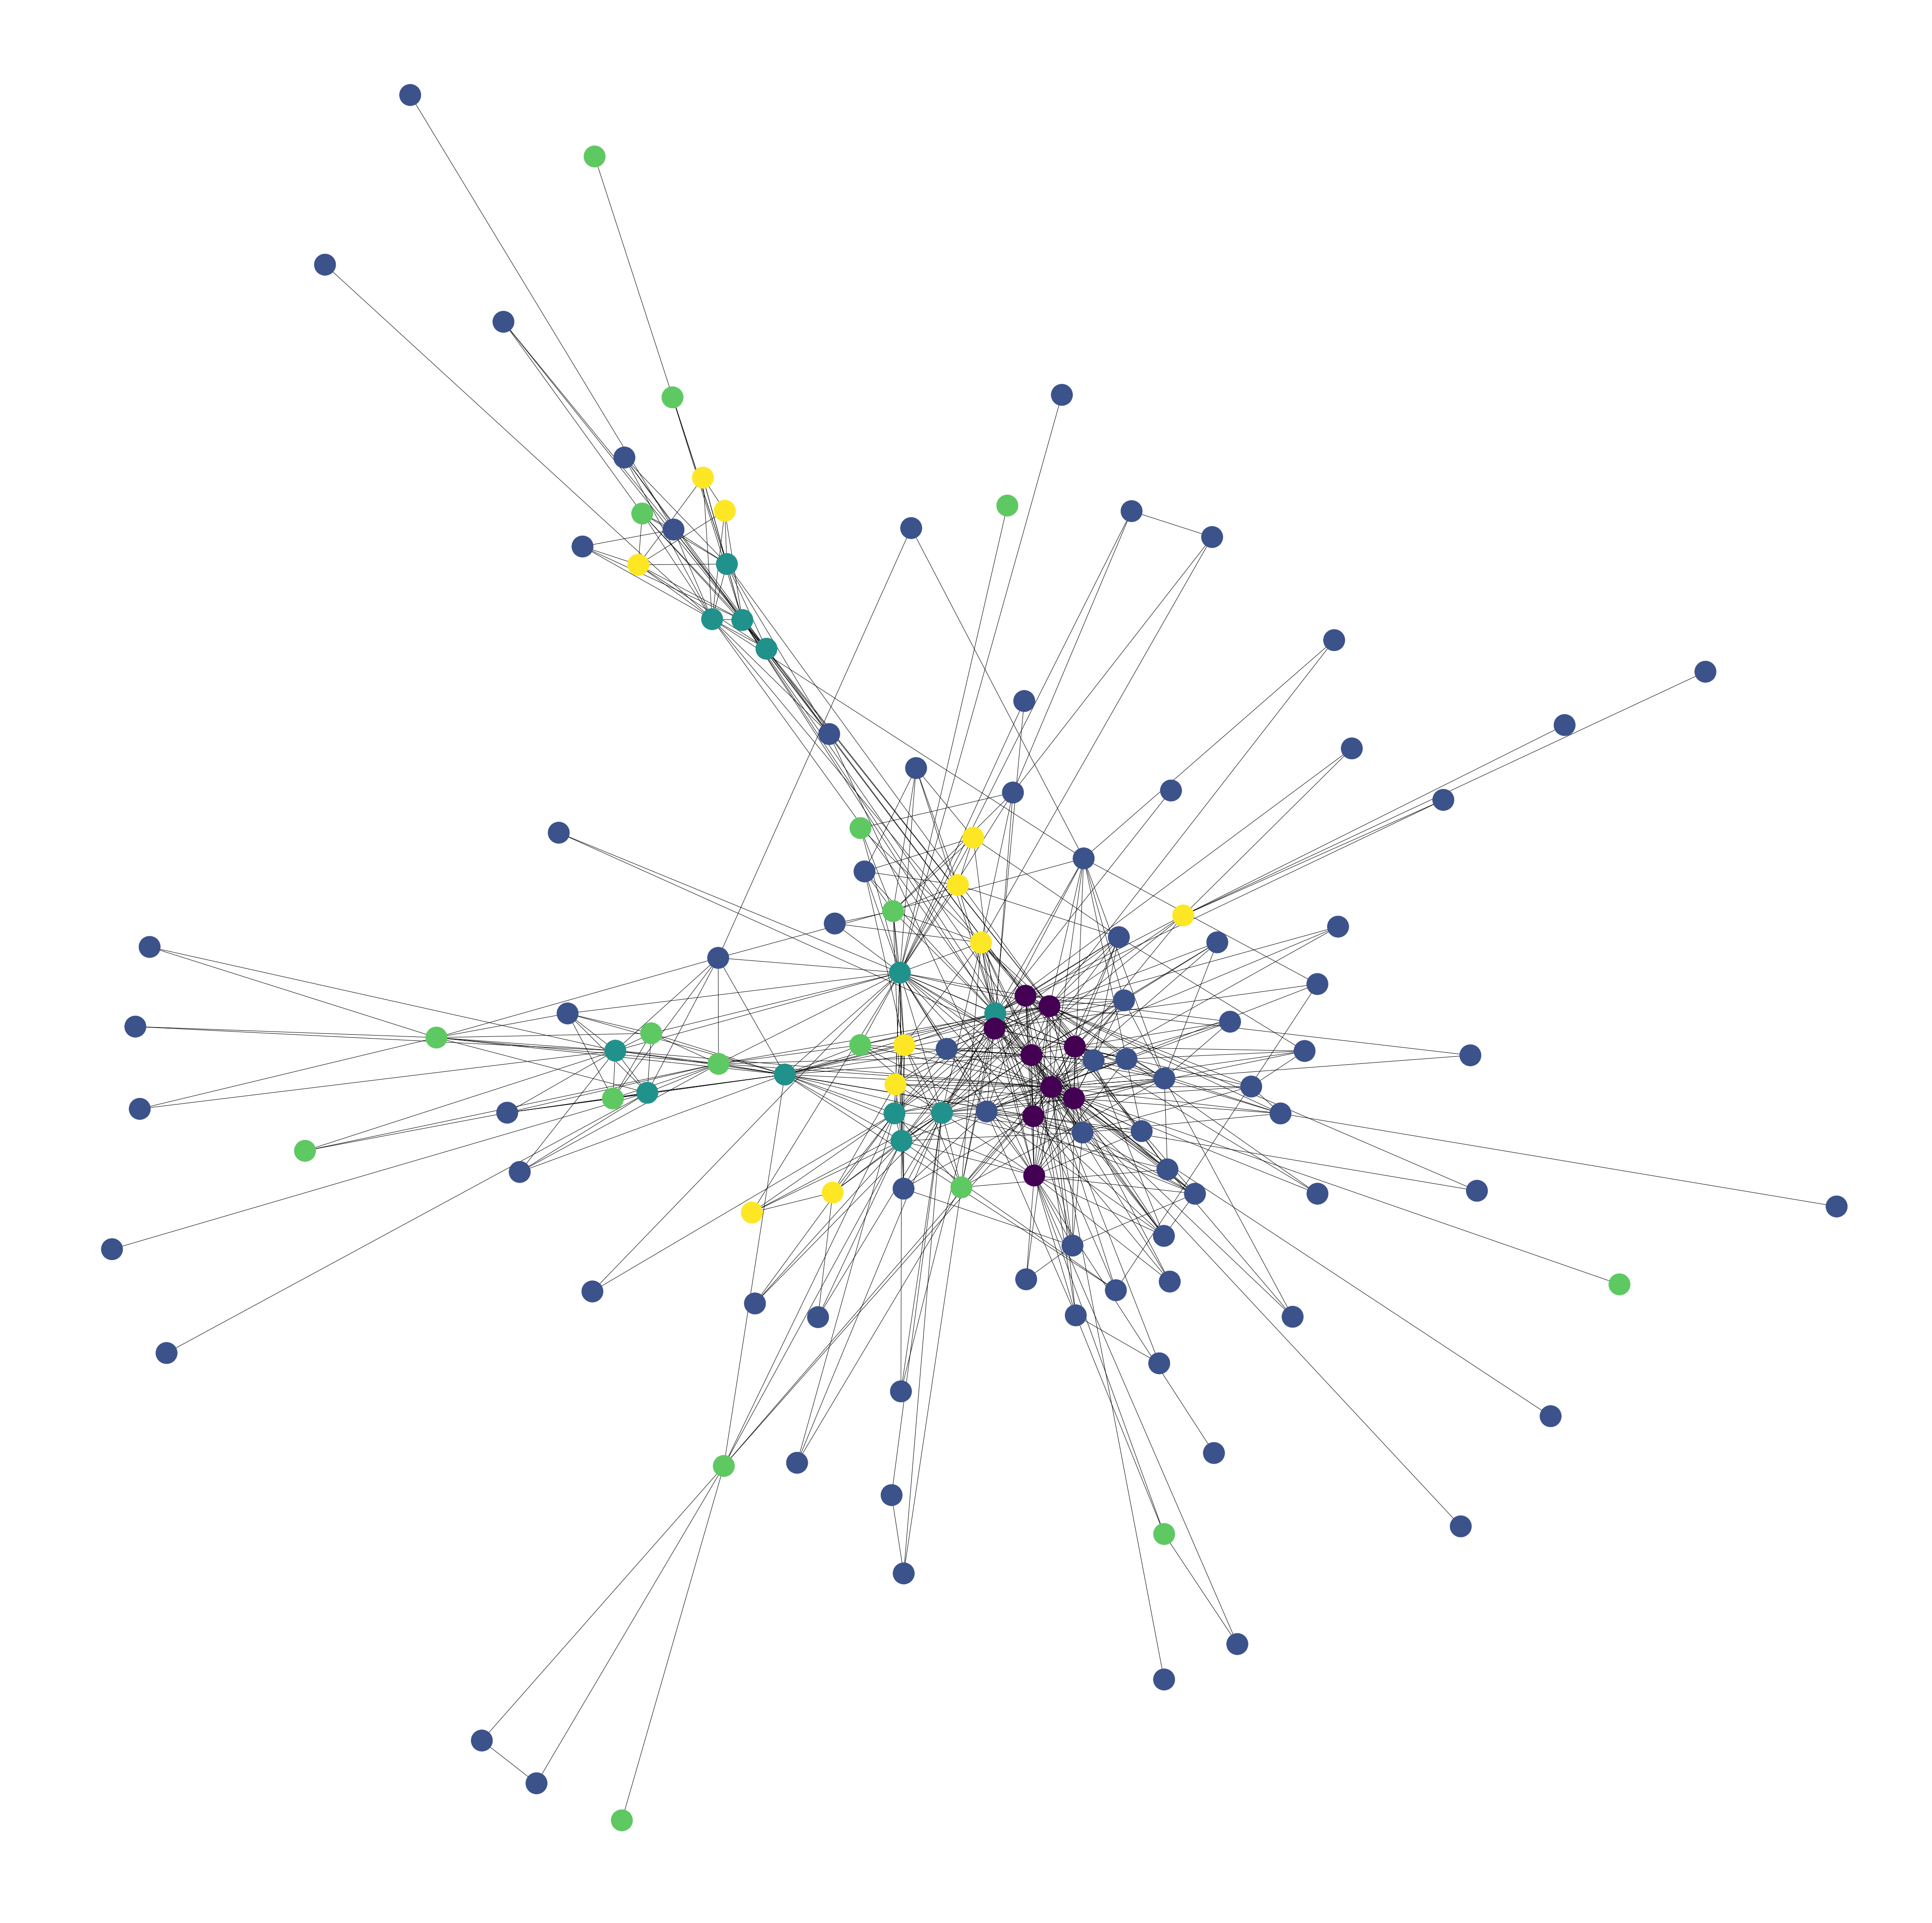

In [112]:
plt.figure(figsize=(60,60))
nx.draw(G, node_color=groups, node_size=2400, label = nodes["Label"], with_labels=False)

If we look at the graph we can see that most of the groups seem to be spread everywhere except the purple group. We now extract the characters corresponding to that group

In [125]:
group0 = []
group1 = []
group2 = []
group3 = []
group4 = []

for x in np.where(groups == 0)[0]:
    group0.append(nodes["Id"][x])

group1 = []
for x in np.where(groups == 1)[0]:
    group1.append(nodes["Id"][x])

group2 = []
for x in np.where(groups == 2)[0]:
    group2.append(nodes["Id"][x])

group3 = []
for x in np.where(groups == 3)[0]:
    group3.append(nodes["Id"][x])

group4 = []
for x in np.where(groups == 4)[0]:
    group4.append(nodes["Id"][x])


In [128]:
for id in group0:
    print(label_dict[id])

Arya
Cersei
Jaime
Joffrey
Petyr
Ned
Robert
Sansa
Varys


So we have 9 characters in the purple group. All of these characters are main characters and all of them are located in King's Landing (a city in GoT) during season 1. Even though the characters are not allies it would make sense to group them together based on the show as they have a lot of interaction.

Next we can look at the graph of this group

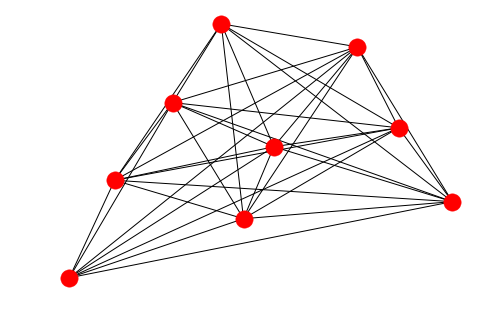

In [130]:
H = G.subgraph(group0)
nx.draw(H, node_size=300)

We can see that the purple group form a fully connected graph, hence all of the characters in the group have at least one interaction with each other.

# Predicting held-out links
A way to assess our model is to see how well it is able to predict links. That means, we have to hold out some of the elements of $X$ from the likelihood - that is, we treat the missing links as latent variables and see how much probability our model assigns to the links held out.  
This is done by creating a mask of the same size as $X$ with 1's and 0's. If `mask[i,j] == 1` then `X[i,j]` is observed, and otherwise it is hidden from the likelihood. If it is not observed and thus hidden from the likelihood, we can compute its' probability in the `generated quantities` block in STAN.  
This is done by noticing the followng.

We note that
$$p(x_{ij} | X) = \sum_{\boldsymbol{\pi},\lambda} p(x_{i,j}|\boldsymbol{\pi},\lambda)p(\boldsymbol{\pi},\lambda|X)$$
where $\boldsymbol{\pi}$ is the collection of all group membership vectors, and $X$ is the network with all missing links excluded. This can be approximated by
$$p(x_{ij} | X) \approx \frac{1}{M} \sum_{m=1}^M p(x_{i,j} | \boldsymbol{\pi}^{(m)},\lambda^{(m)}, X) = \frac{1}{M} \sum_{m=1}^M \text{Poisson}(x_{ij} |  {\boldsymbol{\pi}_i^{(m)}}^T \lambda^{(m)}\boldsymbol{\pi}_j^{(m)})$$
where $\boldsymbol{\pi}^{(m)}$ is the $m$'th posterior sample of $\boldsymbol{\pi}$ and similarly for $\lambda$.

This allows us to compute a score for each of the held-out links. The STAN code is seen below.

In [ ]:
model_code_pred= """
data{
        int<lower=1> N;                    // number of nodes
        int X[N,N];                       // adjacency matrix
        int<lower=2> K;                   // number of groups
        vector[K] alpha;                  // prior for dirichlet distribution
        real a;                           // priors on lambda
        real b;                           // priors on lambda
        real c;
        real d;
        
        int N_missing;                    // how many data points are missing
        int include[N,N];                 // mask to hide data from likelihood
        
} parameters {
        simplex[K] pi[N];                     // group sizes
        matrix<lower=0>[K,K] lambda; // rates between groups
} model{
        for(n in 1:N){
            pi[n] ~ dirichlet(alpha);
        }
        
        for(k in 1:K){
            for(j in 1:K)
                if(j==k){
                    lambda[k,j] ~ gamma(c,d);
                }else{
                    lambda[k,j] ~ gamma(a,b);
                }
        }
        
        for(i in 1:(N-1)){
            for(j in (i+1):N){     // assuming that X is symmetric
                if (include[i,j] == 1) { // check if observed
                    X[i,j] ~ poisson(pi[i]'*lambda*pi[j]);
                }
            }
        }
 
} generated quantities {
        int count = 1;
        real scores[N_missing/2];
        
        // compute scores (ie how likely is the current weight) and make an actual prediction using the samples and then average over samples.
        for (i in 1:(N-1)) {
            for (j in (i+1):N) {
                    if (include[i,j] == 0) {
                        scores[count] = poisson_lpmf(X[i,j] | pi[i]'*lambda*pi[j]);
                        count += 1;
                    }
                }
            }
}
"""

## Discussion

## Conclusion


---
## Litterature
[1] Mikkel N. Schmidt and Morten Mørup. Non-parametric bayesian modeling of complex networks. an introduction. IEEE Signal Processing Magazine, 30(3):110–128, May 2013. [PDF](http://mikkelschmidt.dk/papers/schmidt2013spm.pdf) , [Link to publication](https://ieeexplore.ieee.org/document/6494690)  

[2] Peter D Hoff, Adrian E Raftery & Mark S Handcock (2002) Latent Space Approaches to Social Network Analysis, Journal of the American Statistical Association, 97:460, 1090-1098, DOI: 10.1198/016214502388618906 

[3] Edo  M  Airoldi,  David  M.  Blei,  Stephen  E.  Fienberg,and Eric P. Xing,  “Mixed membership stochastic block-models,”  inAdvances in Neural Information ProcessingSystems 21,  D. Koller,  D. Schuurmans,  Y. Bengio,  andL. Bottou, Eds., pp. 33–40. Curran Associates, Inc., 2009